In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

## Read database

In [2]:
dbfile = "os-sqlite3-data/database.db"
table_name = "searched_books"
query = f"SELECT * FROM {table_name}"
with sqlite3.connect(dbfile) as connection:
    df = pd.read_sql_query(query, connection)

In [3]:
df.columns

Index(['id', 'title', 'authors', 'is_found_a', 'is_found_b', 'search_count_a',
       'search_count_b', 'search_terms_a', 'search_terms_b',
       'search_begin_time_utc', 'found_time_utc_a', 'found_time_utc_b',
       'search_end_time_utc', 'uid'],
      dtype='object')

In [4]:
# Convert missing values and booleans
df.replace("undefined", None, inplace=True)
df[["is_found_a", "is_found_b"]] = df[["is_found_a", "is_found_b"]].replace(
    "true", True
)  # , inplace=True)
df[["is_found_a", "is_found_b"]] = df[["is_found_a", "is_found_b"]].replace(
    "false", False
)  # , inplace=True)

# Convert timestamps in string format to datetime
df["search_begin_time_utc"] = pd.to_datetime(df["search_begin_time_utc"])
df["search_end_time_utc"] = pd.to_datetime(df["search_end_time_utc"])
df["found_time_utc_a"] = pd.to_datetime(df["found_time_utc_a"])
df["found_time_utc_b"] = pd.to_datetime(df["found_time_utc_b"])

# Calculate durations in seconds
df["search_duration_a"] = (
    df["found_time_utc_a"] - df["search_begin_time_utc"]
).dt.total_seconds()
df["search_duration_b"] = (
    df["found_time_utc_b"] - df["search_begin_time_utc"]
).dt.total_seconds()
df["duration_to_proceed"] = (
    df["search_end_time_utc"] - df["search_begin_time_utc"]
).dt.total_seconds()

df.head()

,id,title,authors,is_found_a,is_found_b,search_count_a,search_count_b,search_terms_a,search_terms_b,search_begin_time_utc,found_time_utc_a,found_time_utc_b,search_end_time_utc,uid,search_duration_a,search_duration_b,duration_to_proceed
0,1,Ennen lintuja,"Mäki, Merja",True,True,1,1,"evakot, karjalaiset,","evakot, karjalaiset,",2023-10-26 07:12:48.956000+00:00,2023-10-26 07:13:43.379000+00:00,2023-10-26 07:13:31.340000+00:00,2023-10-26 07:13:46.940000+00:00,c6db0b23-dc9c-431c-b79f-906970f20819,54.423,42.384,57.984
1,2,Valta ja kunnia,"Pietikäinen, Markku",True,True,1,1,"diktaattorit, pako, luostarit,","diktaattorit, pako, luostarit,",2023-10-26 07:13:22.888000+00:00,2023-10-26 07:13:54.981000+00:00,2023-10-26 07:13:58.342000+00:00,2023-10-26 07:14:01.034000+00:00,c8b2867d-d92e-4f50-8f78-88511db06b50,32.093,35.454,38.146
2,3,Murhaballadit,"Horkka, A. R. S.",True,False,2,None,"black metal,",None,2023-10-26 07:13:06.224000+00:00,2023-10-26 07:14:04.395000+00:00,NaT,2023-10-26 07:14:09.544000+00:00,3338e54e-36b0-46c9-8a58-9107991ddb39,58.171,NaN,63.320
3,4,Äänisen tuhopartiot,"Sirén, Esa",True,True,2,2,"kaukopartiot, jatkosota, sotakirjallisuus,","kaukopartiot, jatkosota, sotakirjallisuus,",2023-10-26 07:13:00.171000+00:00,2023-10-26 07:14:06.025000+00:00,2023-10-26 07:14:09.757000+00:00,2023-10-26 07:14:15.128000+00:00,8a51dd7d-145d-429b-b691-f43dfdf658a8,65.854,69.586,74.957
4,5,Juha Mats,,False,False,None,None,None,None,2023-10-26 07:11:50.978000+00:00,NaT,NaT,2023-10-26 07:14:48.261000+00:00,a0cb9c5a-ec28-482c-b50d-3ae8ec906f3e,NaN,NaN,177.283


In [5]:
# Uniformize titles
df.title.replace("Aino ja Kohtaloita", "Aino ja kohtaloita", inplace=True)
df.title.replace("Juha mats", "Juha Mats", inplace=True)
df.title.replace(
    "Pyörätuoli", "Pyörätuolisuperi ja tehtävä Kotkavuorella", inplace=True
)
df.title.replace(
    "Pyörätuolisuperi", "Pyörätuolisuperi ja tehtävä Kotkavuorella", inplace=True
)
df.title.replace("Lucinda Riley", "Auroran salaisuus", inplace=True)

## Books searched 

In [6]:
sorted(df["title"].unique())

['',
 'Aino ja kohtaloita',
 'Aistienvartija',
 'Auroran salaisuus',
 'Elokuussa minä kuolen',
 'Ennen lintuja',
 'Etsiväkaverit salaviestien jäljllä',
 'Juha Mats',
 'Kauno etsii töitä',
 'Kulmakauppa Cockleberry Bayssa',
 'Kuolema Kulosaaressa',
 'Lastensairaala',
 'Lauseita päivään',
 'Liekinkantajat',
 'Los Angeles -esseet',
 'Luokkakaverit',
 'Maailma on minun',
 'Muamo',
 'Murhaballadit',
 'Musta Prinssi',
 'Nainen joka katosi',
 'Nenättömän miehen salaisuus',
 'Orikinellit',
 'Paha kurki',
 'Pikku Myyn ötökkäkirja',
 'Puutalokaupungin naiset',
 'Pyörätuolisuperi ja tehtävä Kotkavuorella',
 'Saanantauti',
 'Salaisuuksia Cockleberry Bayssa',
 'Serkkuteoria',
 'Sushipuu',
 'Valta ja kunnia',
 'Vanhat sarvet',
 'Veikko tahtoo ulos',
 'virhenäppäily',
 'Äänisen tuhopartiot']

## Etsintäkertoja

In [7]:
len(df)

235

## Kirjoja löydettiin

In [8]:
df[
    [
        "is_found_a",
        "is_found_b",
    ]
].sum().to_frame(name="Successful searches sum").T

,is_found_a,is_found_b
Successful searches sum,189,162


## Kirjoja löydettiin -osuus

In [9]:
df[
    [
        "is_found_a",
        "is_found_b",
    ]
].mean().to_frame(
    name="Successful searches share"
).T * 100  # to percentage

,is_found_a,is_found_b
Successful searches share,80.425532,68.93617


## Kirjan löytymiseen tarvittavat haut

<Axes: >

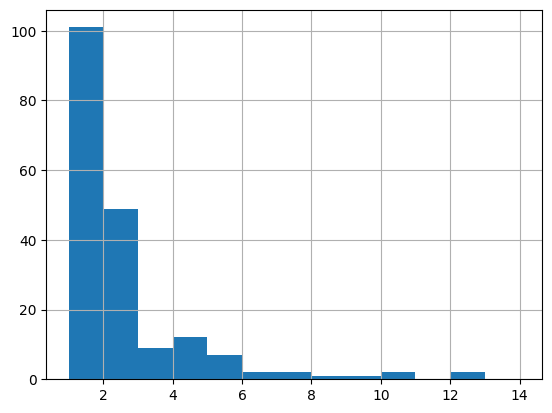

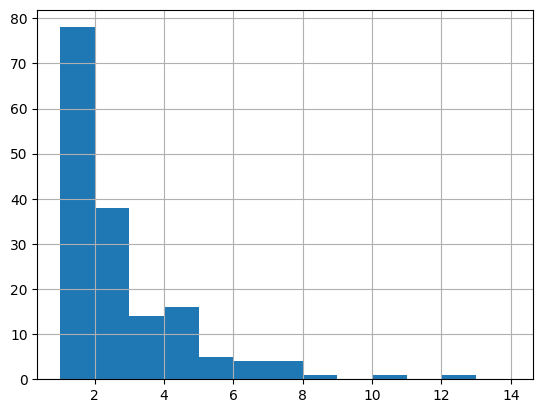

In [10]:
# search_count_x is the number of searches performed when a book is selected

bins = range(1, 15)
df.search_count_a.hist(bins=bins)
plt.figure()
df.search_count_b.hist(bins=bins)

### Keskiarvo

In [11]:
df[
    [
        "search_count_a",
        "search_count_b",
    ]
].mean().to_frame().T

,search_count_a,search_count_b
0,2.174603,2.265432


### Mediaani

In [12]:
df[
    [
        "search_count_a",
        "search_count_b",
    ]
].median().to_frame().T

,search_count_a,search_count_b
0,1.0,2.0


## Kirjan löytymiseen tarvittava aika

array([[<Axes: title={'center': 'search_duration_a'}>,
        <Axes: title={'center': 'search_duration_b'}>]], dtype=object)

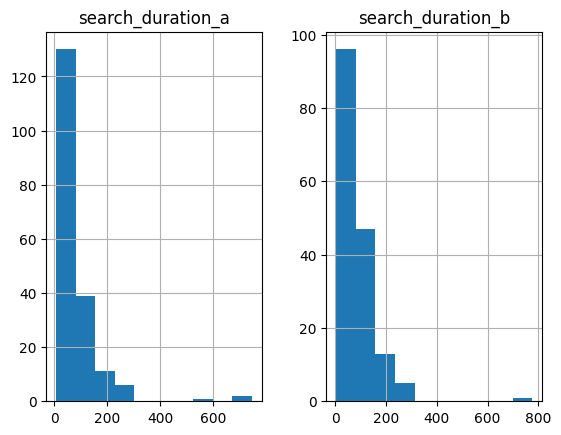

In [13]:
# search_duration_x is the time from starting input in search field until selecting a book

df[
    [
        "search_duration_a",
        "search_duration_b",
    ]
].hist()

### Keskiarvo

In [14]:
print(df[df.search_duration_a < 400].search_duration_a.mean())
print(df[df.search_duration_b < 400].search_duration_b.mean())

69.14794086021506
77.86211801242236


### Mediaani

In [15]:
print(df[df.search_duration_a < 400].search_duration_a.median())
print(df[df.search_duration_b < 400].search_duration_b.median())

52.6105
62.161


# Best searcher

In [16]:
dbfile = "os-sqlite3-data/database.db"
table_name = "users"
query = f"SELECT * FROM {table_name}"
with sqlite3.connect(dbfile) as connection:
    df_users = pd.read_sql_query(query, connection)
df_with_users = df.merge(df_users, on="uid")
df_with_users.sort_values("id", inplace=True)

## The user that found the greatest number of books (either from A or B)

In [17]:
df_users_found = pd.concat(
    [
        df_with_users["user_number"],
        df_with_users[["is_found_a", "is_found_b"]].any(axis=1),
    ],
    axis=1,
)
df_users_found.groupby(by="user_number")[0].sum().sort_values(ascending=False).to_frame(
    name="Number of found books"
)

,Number of found books
user_number,
16,16
13,15
3,14
8,14
4,13
5,13
2,13
10,12
18,12


## The user that found the greatest percentage of books (either from A or B)

In [18]:
df_users_found = pd.concat(
    [
        df_with_users["user_number"],
        df_with_users[["is_found_a", "is_found_b"]].any(axis=1),
    ],
    axis=1,
)
df_users_found.groupby(by="user_number")[0].mean().sort_values(
    ascending=False
).to_frame(name="Percentage of successfull searches") * 100

,Percentage of successfull searches
user_number,
16,100.000000
4,100.000000
6,100.000000
11,100.000000
12,100.000000
13,100.000000
14,100.000000
3,93.333333
8,93.333333


## The user that found the greatest number of books (sum from both A and B)

In [19]:
df_with_users.groupby(by="user_number")[["is_found_a", "is_found_b"]].sum().sum(
    axis=1
).sort_values(ascending=False).to_frame(name="Number of found books")

,Number of found books
user_number,
16,27
13,25
4,24
5,24
2,24
11,23
8,22
3,21
10,20


## TODO Plots?


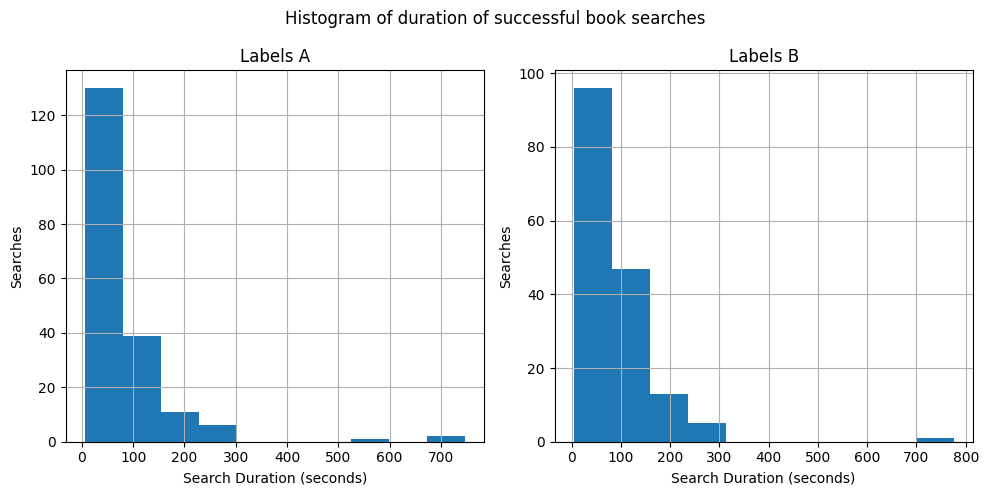

In [20]:
# Create a subplot with two histograms
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
bins = list(range(0, 300, 20))

# Subplot for 'labels_set' == 'a'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
df.search_duration_a.hist()  # bins=bins)
plt.xlabel("Search Duration (seconds)")
plt.ylabel("Searches")
plt.title("Labels A")

# Subplot for 'labels_set' == 'b'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
df.search_duration_b.hist()  # bins=bins)
plt.xlabel("Search Duration (seconds)")
plt.ylabel("Searches")
plt.title("Labels B")

plt.suptitle("Histogram of duration of successful book searches")
plt.tight_layout()  # Adjusts subplot parameters for better spacing
plt.show()

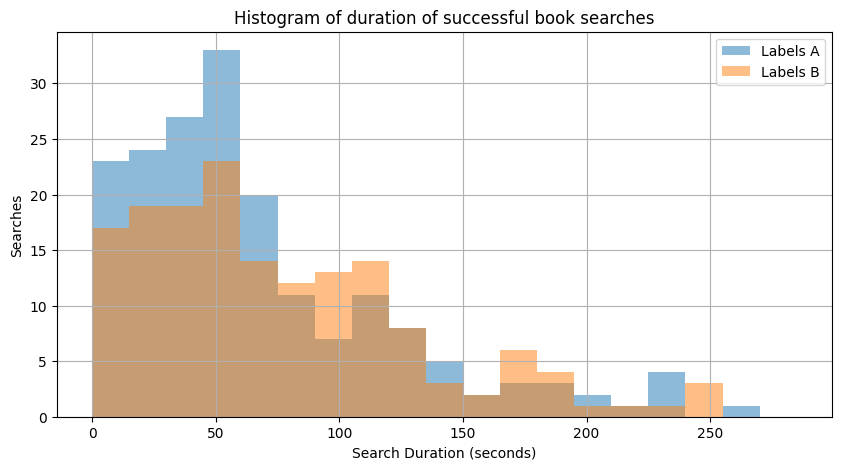

In [21]:
# Create a single histogram with both sets of data
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
bins = list(range(0, 300, 15))

# Plot histogram for 'labels_set' == 'a'
df[df.search_duration_a < 300].search_duration_a.hist(
    bins=bins, alpha=0.5, label="Labels A"
)  # alpha adds transparency

# Plot histogram for 'labels_set' == 'b'
df[df.search_duration_b < 300].search_duration_b.hist(
    bins=bins, alpha=0.5, label="Labels B"
)  # alpha adds transparency

plt.xlabel("Search Duration (seconds)")
plt.ylabel("Searches")
plt.title("Histogram of duration of successful book searches")
plt.legend()  # Add legend to distinguish between 'Labels A' and 'Labels B'
plt.show()

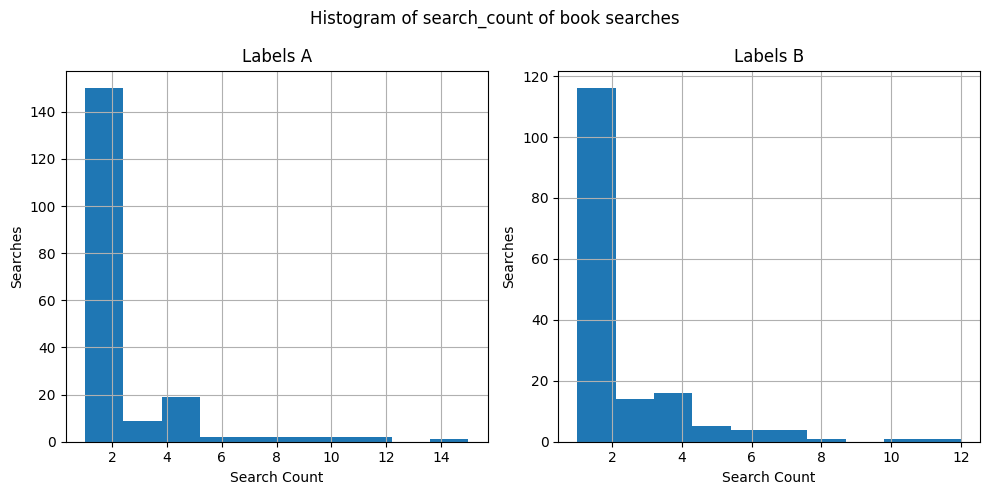

In [22]:
# Create a subplot with two histograms
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
# bins = list(range(0, 300, 20))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
df.search_count_a.hist()  # bins=bins)
plt.xlabel("Search Count")
plt.ylabel("Searches")
plt.title("Labels A")

# Subplot for 'labels_set' == 'b'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
df.search_count_b.hist()  # bins=bins)
plt.xlabel("Search Count")
plt.ylabel("Searches")
plt.title("Labels B")

plt.suptitle("Histogram of search_count of book searches")
plt.tight_layout()  # Adjusts subplot parameters for better spacing
plt.show()

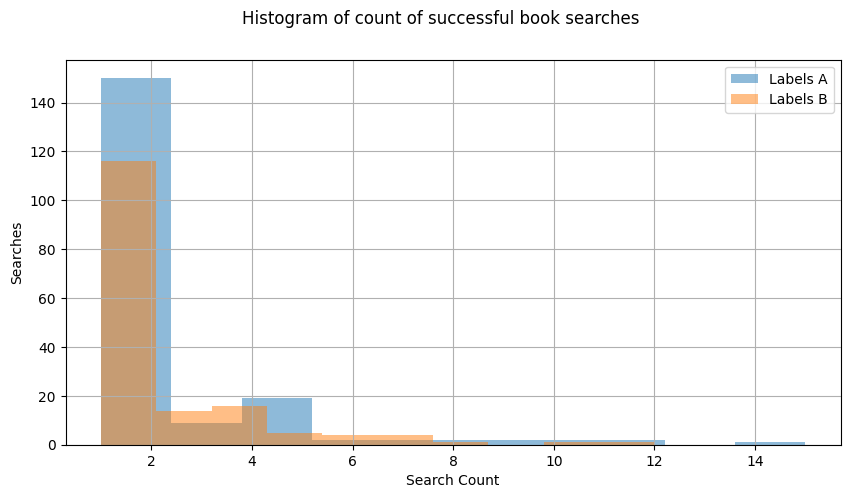

In [23]:
# Create a single histogram with both sets of data
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
bins = None  # list(range(0, 7, 7))

# Plot histogram for 'labels_set' == 'a'
df.search_count_a.hist(
    bins=bins, alpha=0.5, label="Labels A"
)  # alpha adds transparency

# Plot histogram for 'labels_set' == 'b'
df.search_count_b.hist(
    bins=bins, alpha=0.5, label="Labels B"
)  # alpha adds transparency

plt.xlabel("Search Count")
plt.ylabel("Searches")
plt.suptitle("Histogram of count of successful book searches")
plt.legend()  # Add legend to distinguish between 'Labels A' and 'Labels B'
plt.show()

## Easiest books to find

/tmp/ipykernel_93455/268467948.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pruned = df[df.title != 'virhenäppäily'][df.title != 'Salaisuuksia Cockleberry Bayssa'][df.title != '']
/tmp/ipykernel_93455/268467948.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pruned = df[df.title != 'virhenäppäily'][df.title != 'Salaisuuksia Cockleberry Bayssa'][df.title != '']


Text(0.5, 0, 'Löytöjen määrä')

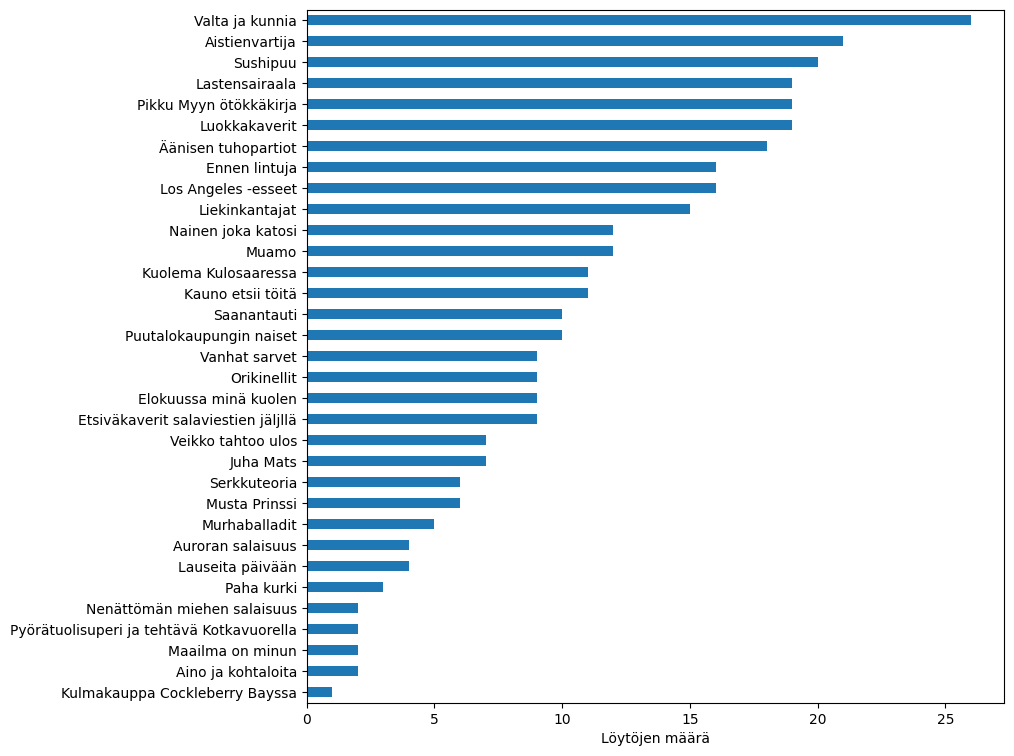

In [33]:
df_pruned = df[df.title != "virhenäppäily"][
    df.title != "Salaisuuksia Cockleberry Bayssa"
][df.title != ""]

# Altogether, with Kirjasampo & Annif subjects
col = ["is_found_a", "is_found_b"]
df_pruned.groupby(by="title")[col].sum().sum(axis=1).sort_values(
    ascending=True
).to_frame(name="Found times").plot.barh(figsize=(9, 9), legend=False)
plt.ylabel(None)
plt.xlabel("Löytöjen määrä")

Text(0.5, 0, 'Löytöjen osuus')

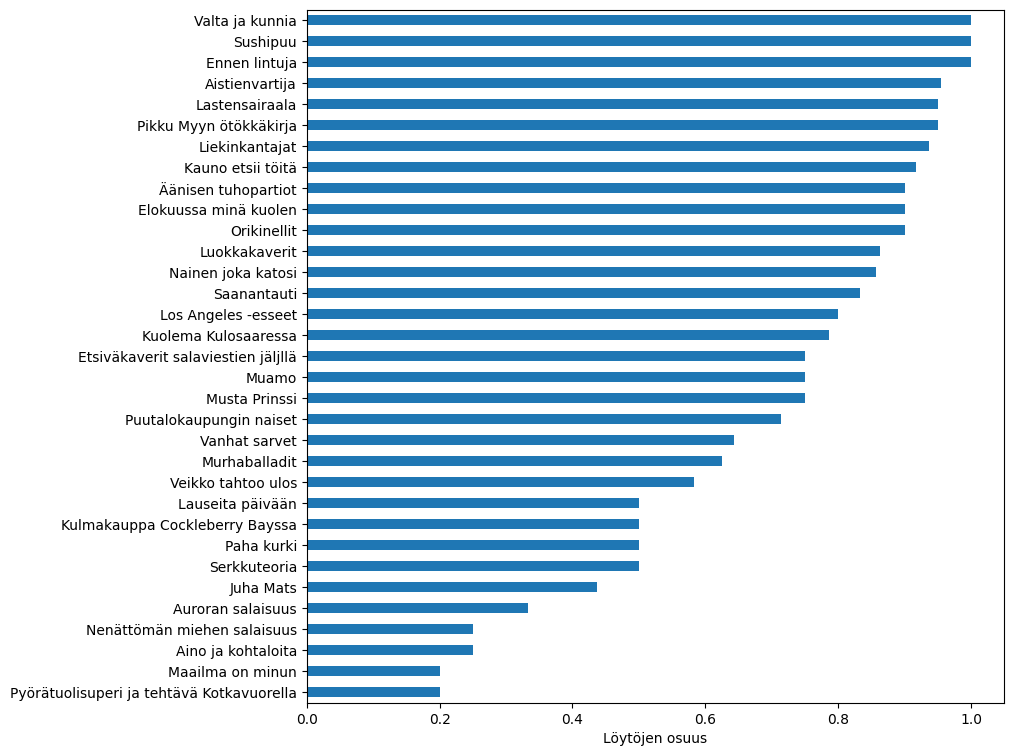

In [34]:
# Altogether, with Kirjasampo & Annif subjects
col = ["is_found_a", "is_found_b"]
df_pruned.groupby(by="title")[col].mean().mean(axis=1).sort_values(
    ascending=True
).to_frame(name="Found share").plot.barh(figsize=(9, 9), legend=False)
plt.ylabel(None)
plt.xlabel("Löytöjen osuus")

Text(0.5, 0, 'Löytöjen osuus')

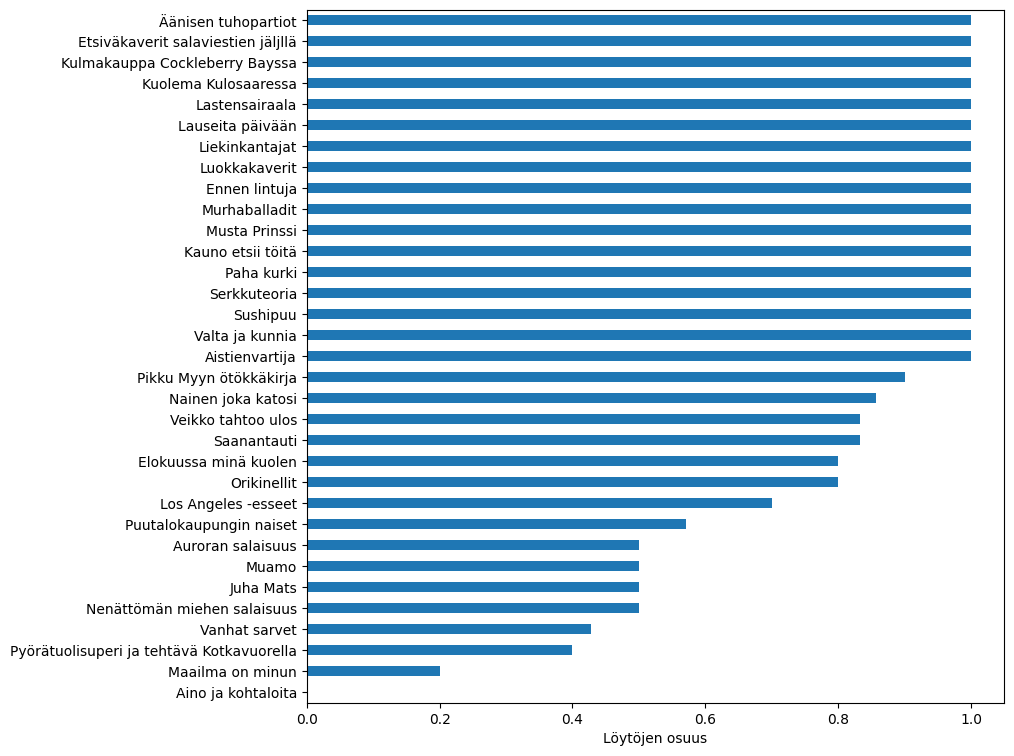

In [35]:
col = ["is_found_a"]
df_pruned.groupby(by="title")[col].mean().mean(axis=1).sort_values(
    ascending=True
).to_frame(name="Found share").plot.barh(figsize=(9, 9), legend=False)
plt.ylabel(None)
plt.xlabel("Löytöjen osuus")

Text(0.5, 0, 'Löytöjen osuus')

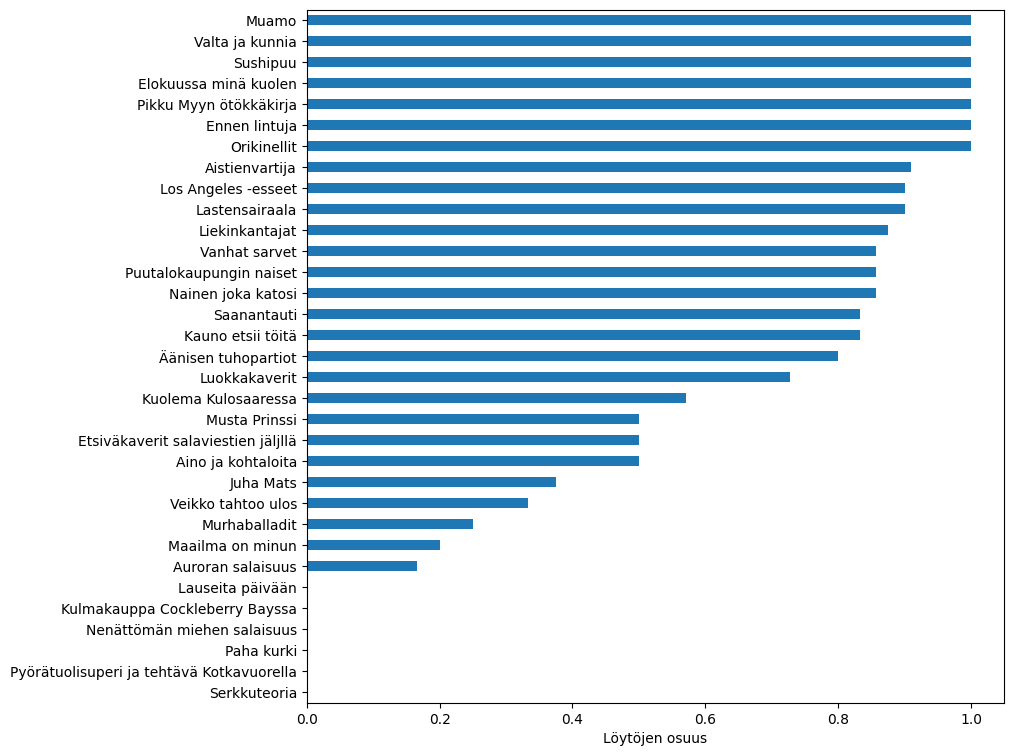

In [36]:
col = ["is_found_b"]
df_pruned.groupby(by="title")[col].mean().mean(axis=1).sort_values(
    ascending=True
).to_frame(name="Found share").plot.barh(figsize=(9, 9), legend=False)
plt.ylabel(None)
plt.xlabel("Löytöjen osuus")

Text(0.5, 0, 'Löytöjen määrä, Annif - Kirjasampo')

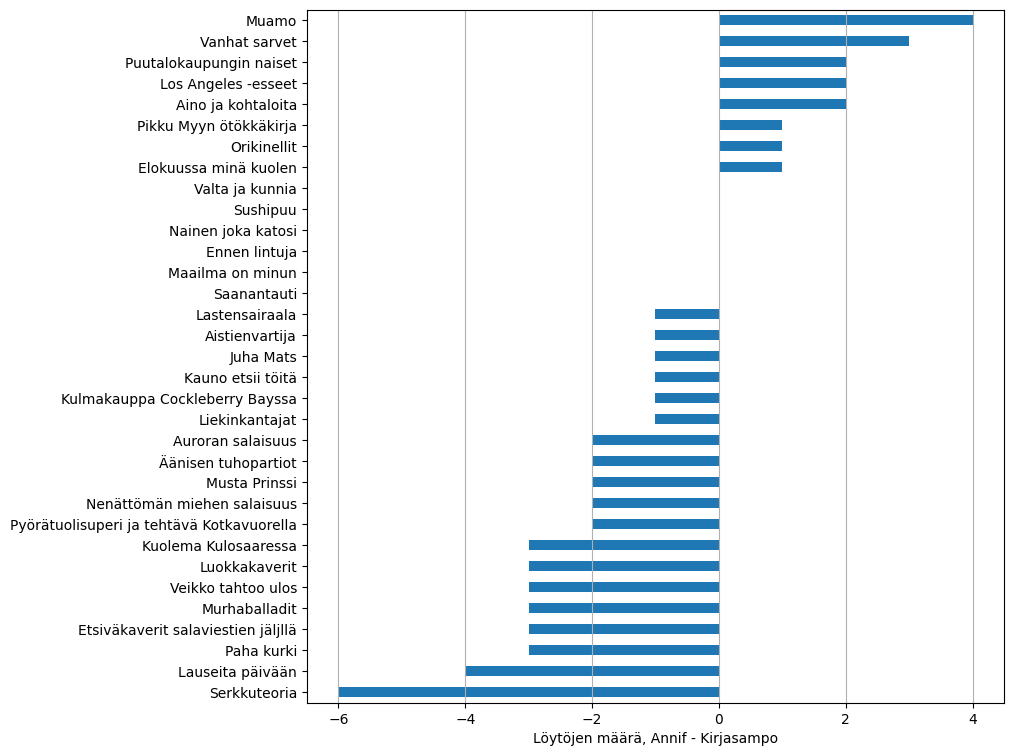

In [37]:
# Difference
diff = (
    df_pruned.groupby(by="title")[
        [
            "is_found_a",
            "is_found_b",
        ]
    ]
    .sum()
    .diff(axis=1)
    .iloc[:, 1]
)
diff.sort_values().to_frame().plot.barh(figsize=(9, 9), legend=False)
plt.grid(axis="x")
plt.ylabel(None)
plt.xlabel("Löytöjen määrä, Annif - Kirjasampo")